Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality, Duration And Cyclic Time

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
############################
#SAMPLE
#dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
#df = dfa.sample(n=70000, random_state=1).copy()

df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.000000,1.000000
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.000000,1.000000
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333,23,5,1,-0.258819,0.965926,-0.974928,-0.222521
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000,23,5,1,-0.258819,0.965926,-0.974928,-0.222521


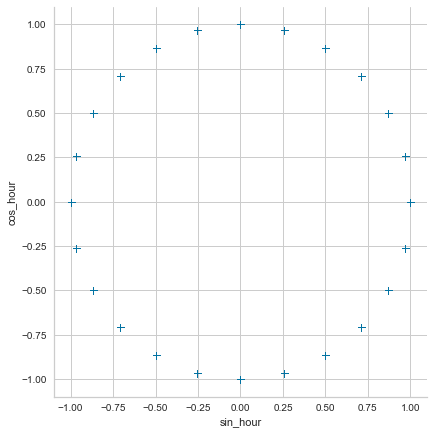

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

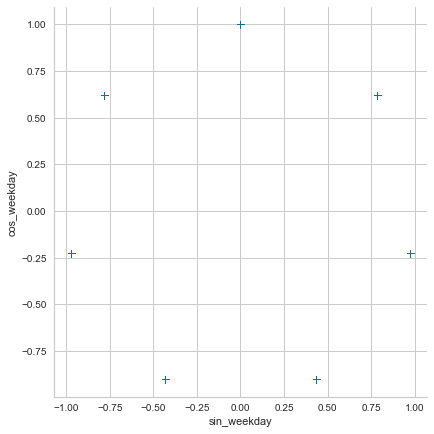

In [7]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

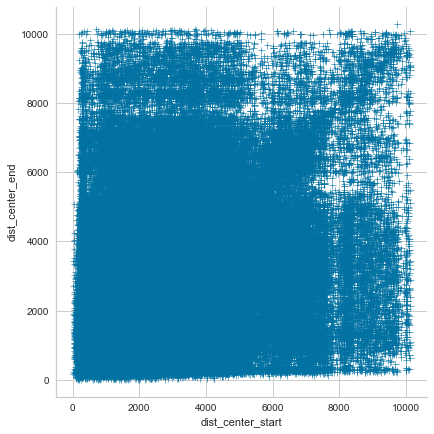

In [8]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
#df = df.drop(df[(df['dist_center_start']>11000)&(df['dist_center_end']>11000)].index, inplace=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekday'),
  Text(5, 0, 'weekend'),
  Text(6, 0, 'sin_hour'),
  Text(7, 0, 'cos_hour'),
  Text(8, 0, 'sin_weekday'),
  Text(9, 0, 'cos_weekday')])

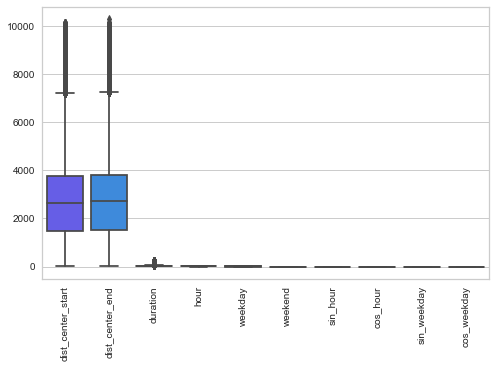

In [9]:
# look at feature skewness
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [10]:
# normalize features to get same range as sin and cos values
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

#dfnorm = df[['dist_center_start','dist_center_end', 'duration']].copy()

dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 1.8

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1.5

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.513469
cos_hour             0.384401
sin_weekday          0.223663
cos_weekday          0.218842
dist_center_start    0.548566
dist_center_end      0.551122
duration             0.510852
weekend              0.147749
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'dist_center_start'),
  Text(5, 0, 'dist_center_end'),
  Text(6, 0, 'duration'),
  Text(7, 0, 'weekend')])

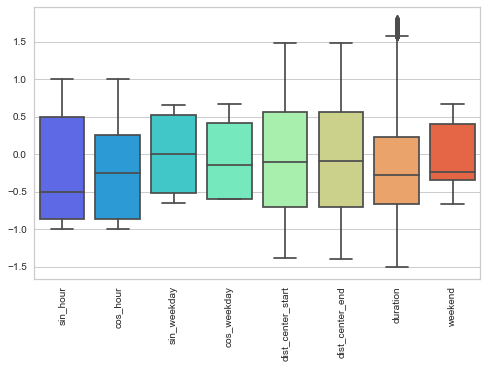

In [11]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

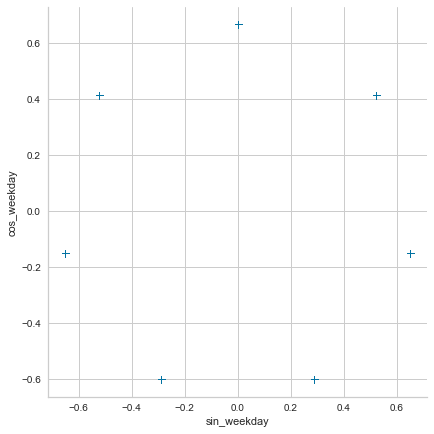

In [12]:
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=scaled_df, marker='+', height=6, aspect=1)

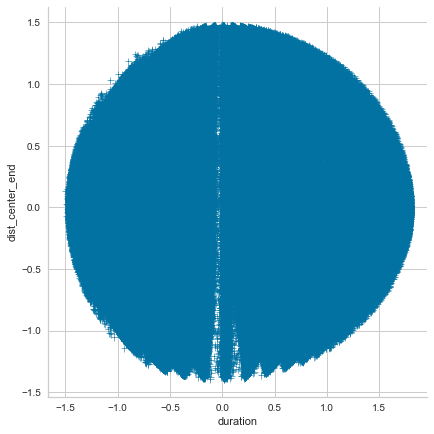

In [13]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="duration", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=6, aspect=1)

### Cluster tendency

In [14]:
# calculate hopkins statistics on subset
from pyclustertend import hopkins
hopkins(scaled_df, 20000)

0.09444850962720339

### Clustering trip types via k-means and parameter selection

#### Parameter selection / clustering performance evaluation

In [15]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

max_num_cluster = 30

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  1020597.7912438184
silhouette:  0.17365566052454354
calinski harabasz:  88104.86493394928
davies bouldin:  2.1090100057294605
3453.2009797096252
3
inertia:  913063.7236747855
silhouette:  0.16621980136613365
calinski harabasz:  72890.88560031676
davies bouldin:  2.028075938596943
2468.070759534836
4
inertia:  826442.2241729146
silhouette:  0.15498184416630628
calinski harabasz:  67718.53435646281
davies bouldin:  1.9136938100563963
2956.496991634369
5
inertia:  760841.6845937768
silhouette:  0.15912374152868214
calinski harabasz:  63824.83257591992
davies bouldin:  1.8660152447307077
2882.625198364258
6
inertia:  711128.1375586682
silhouette:  0.16351938296228832
calinski harabasz:  60244.197153914596
davies bouldin:  1.768434493704248
2576.080969810486
7
inertia:  669148.1072118955
silhouette:  0.16479870165199376
calinski harabasz:  57552.53490939873
davies bouldin:  1.7009714872479016
2508.6699438095093
8
inertia:  634226.1987389014
silhouette:  0.17294701912588556
calin

#### Elbow method

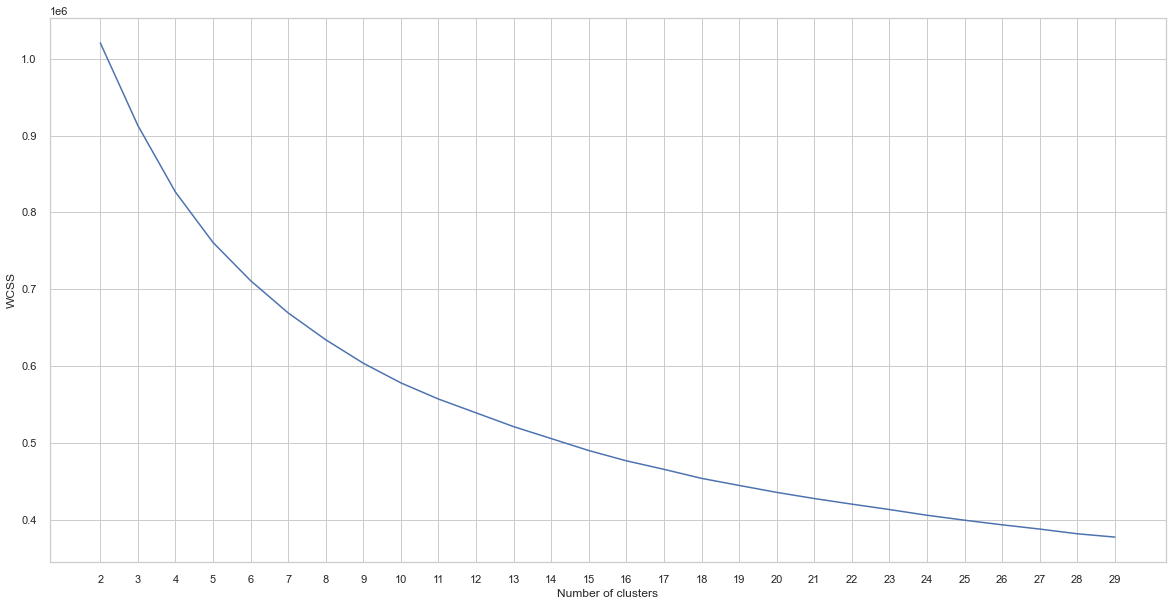

In [57]:
# plot wcss for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
#fig.savefig('elbowPlot2.png', dpi=fig.dpi)

#### Silhouette coefficient

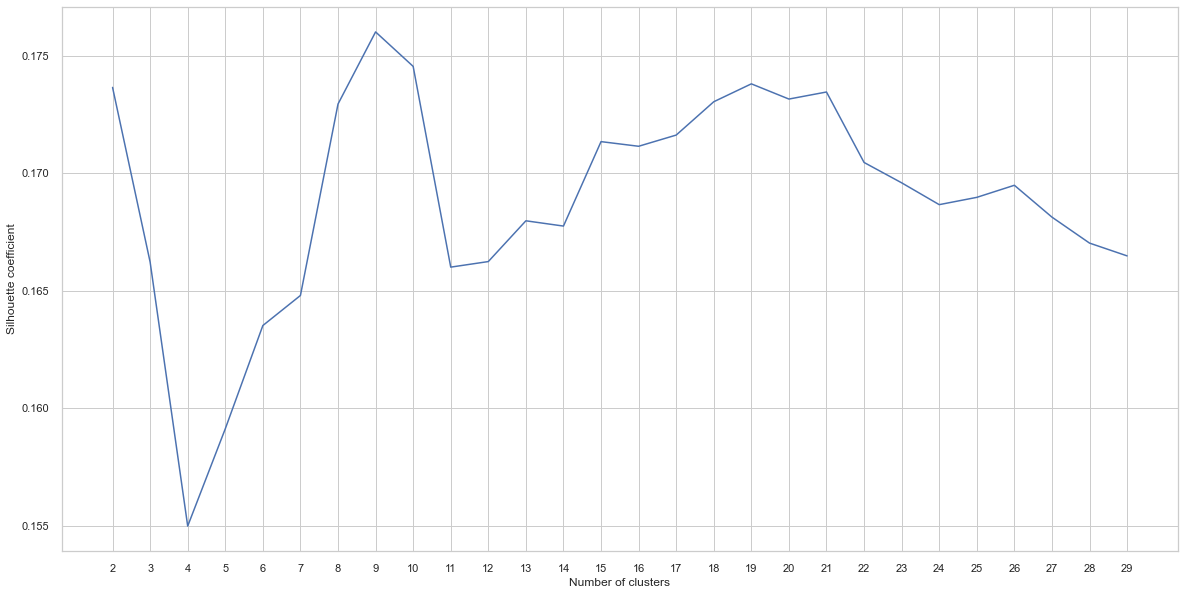

In [55]:
# plot silhouette coefficients for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()
#fig.savefig('silhouetteScore2.png', dpi=fig.dpi)

#### Calinski Harabasz score

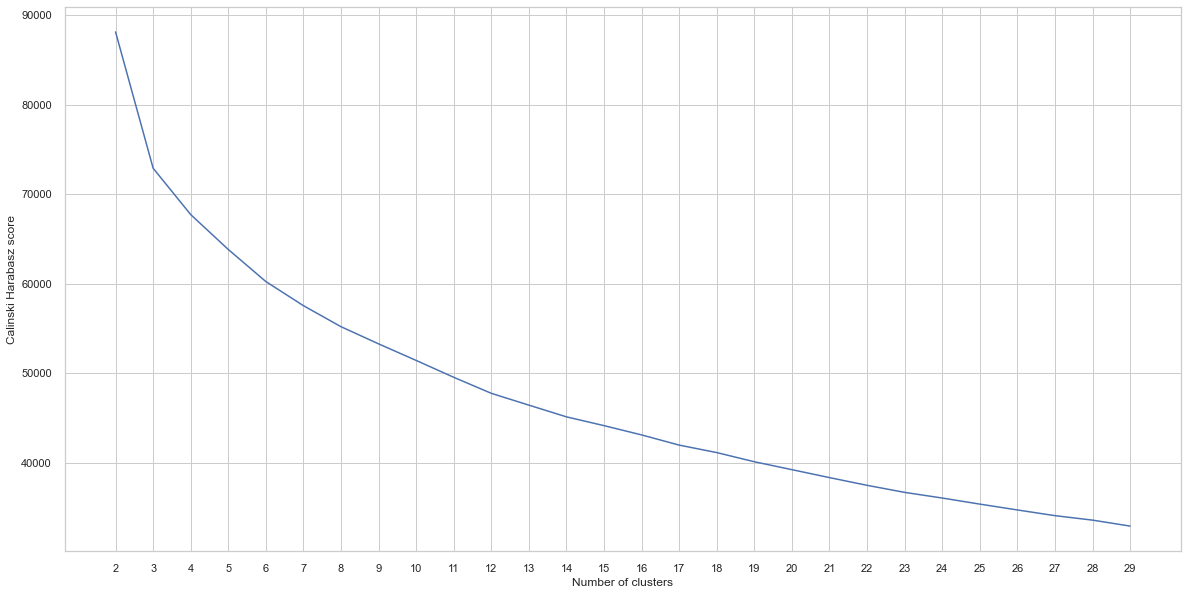

In [53]:
# plot Calinski Harabasz score for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()
#fig.savefig('calinskiHarabaszScore2.png', dpi=fig.dpi)

#### Davies Bouldin index

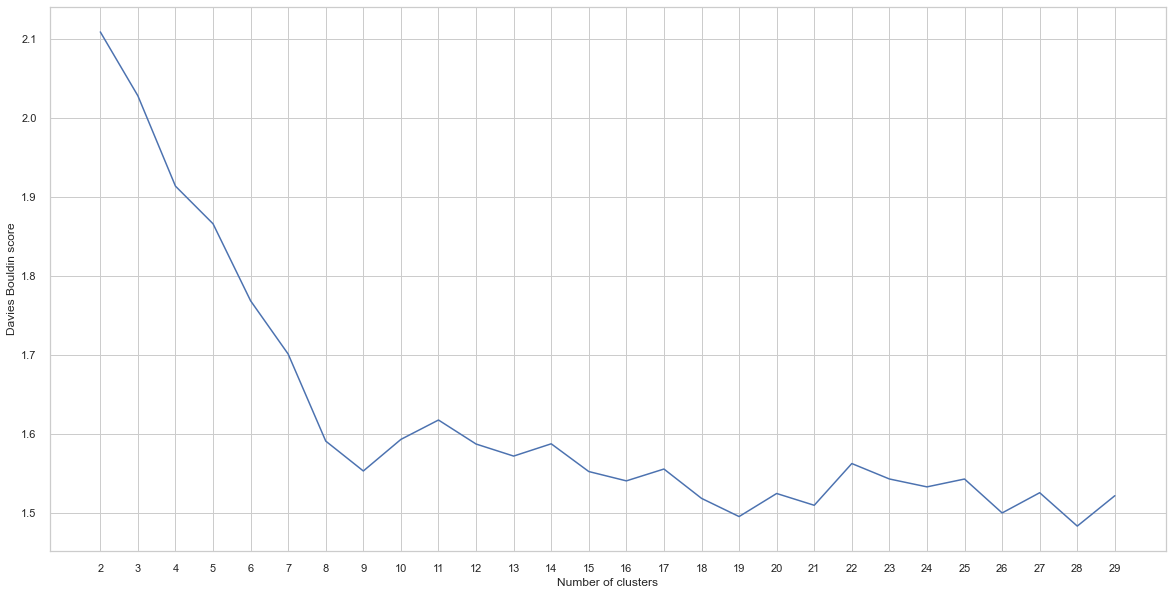

In [51]:
# plot Davies Bouldin scores for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()
#fig.savefig('daviesBouldinScore2.png', dpi=fig.dpi)

#### K-means with selected parameter

In [65]:
# cluster data for the chosen number of clusters
k = 19

kmeans = KMeans(n_clusters=k,  n_init=20, random_state=0).fit(scaled_df)

clustered_data = df.copy()

cluster_labels = kmeans.fit_predict(scaled_df)
clustered_data['cluster'] = cluster_labels
scaled_df['cluster'] = cluster_labels


clustered_data.head()

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,13,0,0,-0.258819,-0.965926,0.0,1.0,0
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,6
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,13,0,0,-0.258819,-0.965926,0.0,1.0,5
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,11
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,13,0,0,-0.258819,-0.965926,0.0,1.0,0


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

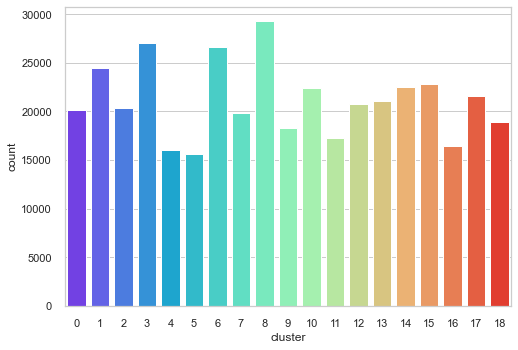

In [66]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Cluster magnitude

In [67]:

#distances = kmeans.fit_transform(scaled_df)
#variance = 0
#i = 0
#for label in kmeans.labels_:
#    variance = variance + distances[i][label]
#    i = i + 1
#variance

#for kmeans.labels_
#inertia_0

#### Cardinality vs magnitude

#### Attribute table

In [73]:
interpret_df = clustered_data[['dist_center_start','dist_center_end','duration', 'weekend','cluster']].copy()
interpret_df = interpret_df.groupby(['cluster']).mean()


time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

interpret_df = interpret_df.join(time_df)

interpret_df['morning 6-12'] = interpret_df[6] + interpret_df[7] + interpret_df[8] + interpret_df[9] + interpret_df[10] + interpret_df[11] + interpret_df[12]
interpret_df['evening 13-20'] = interpret_df[14] + interpret_df[15] + interpret_df[16] + interpret_df[17] + interpret_df[18] + interpret_df[19] + interpret_df[20]


pd.set_option("display.max_rows", None, "display.max_columns", None)
#interpret_df['sum_dist'] = interpret_df['dist_center_start'] + interpret_df['dist_center_end']
#interpret = interpret_df.sort_values(by=['sum_dist'])
interpret = interpret_df
#interpret_df.T.round(2).to_excel("Final-19-15-18-15-15-InterpretClusters.xlsx")  
#interpret_df.to_csv('finalclusters.csv', index=False)
#scaled_df.to_csv('scaledDataWithFinalClusters.csv', index=False)

#interpret = interpret[(interpret['dist_center_start']>3000)&(interpret['dist_center_end']>3000)]
interpret.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
dist_center_start,4969.64,2115.56,1506.32,1779.57,3037.30,1325.68,1586.30,4328.90,1518.95,4207.41,4853.34,3369.43,4699.24,1733.98,2879.05,4231.93,2648.93,2381.12,1731.17
dist_center_end,4869.67,1915.85,1490.50,1872.76,2906.64,4288.15,1590.40,4248.25,1613.49,1261.55,1739.31,3425.75,4040.88,1807.47,2929.87,4139.10,5496.45,2697.06,4550.79
duration,33.75,21.04,17.37,20.93,93.02,32.71,16.98,18.92,15.64,31.80,34.07,12.44,20.67,15.51,85.58,28.17,35.14,19.21,29.65
weekend,0.00,1.00,0.00,1.00,0.18,0.10,0.00,0.08,0.01,0.07,0.11,0.00,0.11,0.00,0.20,1.00,0.13,1.00,0.08
0 Monday,18.08,0.02,0.00,0.00,14.71,17.72,35.58,17.56,19.62,18.02,14.54,17.25,16.58,14.93,15.05,0.00,16.07,0.20,16.37
1 Tuesday,20.20,0.00,0.00,0.00,16.28,16.60,36.35,17.03,21.57,18.35,14.47,18.80,17.92,16.59,14.85,0.00,17.49,0.00,15.65
2 Wednesday,20.82,0.00,0.00,0.00,15.06,17.42,27.45,17.75,20.78,18.11,16.39,19.55,16.38,21.10,14.19,0.00,16.75,0.00,17.61
3 Thursday,19.64,0.00,38.82,0.00,17.70,17.33,0.60,17.06,20.53,19.29,17.38,21.49,19.04,20.34,15.20,0.00,18.23,0.00,18.31
4 Friday,21.26,0.00,61.18,0.00,17.89,20.87,0.02,22.46,16.85,19.38,26.17,22.91,19.25,26.97,20.90,0.00,18.08,0.15,23.93
5 Saturday,0.00,57.57,0.00,62.72,12.71,5.52,0.00,4.97,0.12,3.80,7.71,0.00,6.30,0.06,12.09,58.26,7.64,57.59,4.94


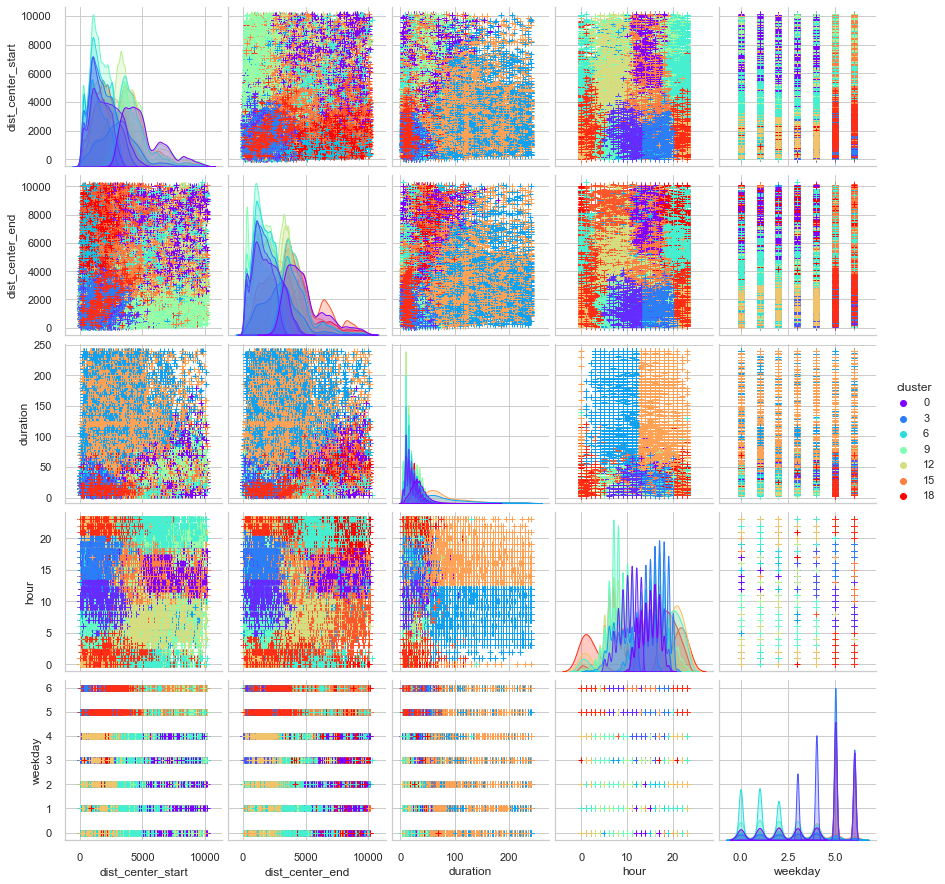

In [69]:
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

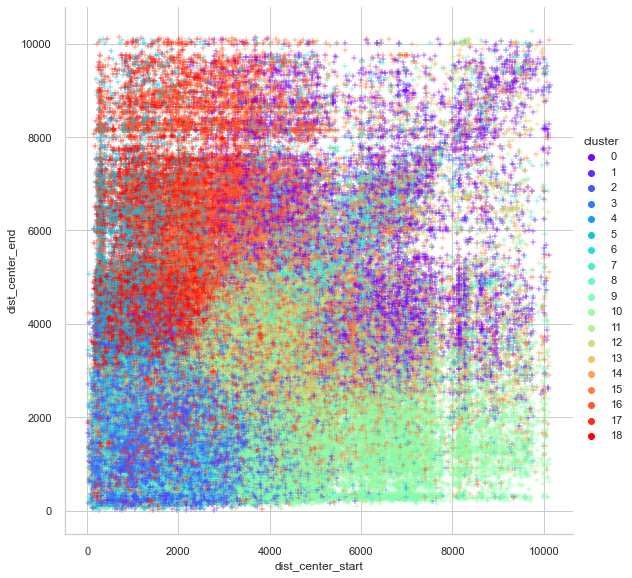

In [70]:
# plot cluster results for two desired features
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

In [74]:
#TSNE_data = scaled_df.copy()
#sampleTSNE = TSNE_data.sample(n=40000, random_state=1).reset_index()
sampleTSNE = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,1:-1]

##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 401622 samples in 1.625s...
[t-SNE] Computed neighbors for 401622 samples in 128.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 401622
[t-SNE] Computed conditional probabilities for sample 2000 / 401622
[t-SNE] Computed conditional probabilities for sample 3000 / 401622
[t-SNE] Computed conditional probabilities for sample 4000 / 401622
[t-SNE] Computed conditional probabilities for sample 5000 / 401622
[t-SNE] Computed conditional probabilities for sample 6000 / 401622
[t-SNE] Computed conditional probabilities for sample 7000 / 401622
[t-SNE] Computed conditional probabilities for sample 8000 / 401622
[t-SNE] Computed conditional probabilities for sample 9000 / 401622
[t-SNE] Computed conditional probabilities for sample 10000 / 401622
[t-SNE] Computed conditional probabilities for sample 11000 / 401622
[t-SNE] Computed conditional probabilities for sample 12000 / 401622
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 120000 / 401622
[t-SNE] Computed conditional probabilities for sample 121000 / 401622
[t-SNE] Computed conditional probabilities for sample 122000 / 401622
[t-SNE] Computed conditional probabilities for sample 123000 / 401622
[t-SNE] Computed conditional probabilities for sample 124000 / 401622
[t-SNE] Computed conditional probabilities for sample 125000 / 401622
[t-SNE] Computed conditional probabilities for sample 126000 / 401622
[t-SNE] Computed conditional probabilities for sample 127000 / 401622
[t-SNE] Computed conditional probabilities for sample 128000 / 401622
[t-SNE] Computed conditional probabilities for sample 129000 / 401622
[t-SNE] Computed conditional probabilities for sample 130000 / 401622
[t-SNE] Computed conditional probabilities for sample 131000 / 401622
[t-SNE] Computed conditional probabilities for sample 132000 / 401622
[t-SNE] Computed conditional probabilities for sample 133000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 246000 / 401622
[t-SNE] Computed conditional probabilities for sample 247000 / 401622
[t-SNE] Computed conditional probabilities for sample 248000 / 401622
[t-SNE] Computed conditional probabilities for sample 249000 / 401622
[t-SNE] Computed conditional probabilities for sample 250000 / 401622
[t-SNE] Computed conditional probabilities for sample 251000 / 401622
[t-SNE] Computed conditional probabilities for sample 252000 / 401622
[t-SNE] Computed conditional probabilities for sample 253000 / 401622
[t-SNE] Computed conditional probabilities for sample 254000 / 401622
[t-SNE] Computed conditional probabilities for sample 255000 / 401622
[t-SNE] Computed conditional probabilities for sample 256000 / 401622
[t-SNE] Computed conditional probabilities for sample 257000 / 401622
[t-SNE] Computed conditional probabilities for sample 258000 / 401622
[t-SNE] Computed conditional probabilities for sample 259000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 364000 / 401622
[t-SNE] Computed conditional probabilities for sample 365000 / 401622
[t-SNE] Computed conditional probabilities for sample 366000 / 401622
[t-SNE] Computed conditional probabilities for sample 367000 / 401622
[t-SNE] Computed conditional probabilities for sample 368000 / 401622
[t-SNE] Computed conditional probabilities for sample 369000 / 401622
[t-SNE] Computed conditional probabilities for sample 370000 / 401622
[t-SNE] Computed conditional probabilities for sample 371000 / 401622
[t-SNE] Computed conditional probabilities for sample 372000 / 401622
[t-SNE] Computed conditional probabilities for sample 373000 / 401622
[t-SNE] Computed conditional probabilities for sample 374000 / 401622
[t-SNE] Computed conditional probabilities for sample 375000 / 401622
[t-SNE] Computed conditional probabilities for sample 376000 / 401622
[t-SNE] Computed conditional probabilities for sample 377000 / 401622
[t-SNE] Computed con

array([[106.29852 ,  12.080965],
       [ 81.82028 ,  74.16445 ],
       [113.04526 ,  74.48475 ],
       ...,
       [ 72.80047 , -22.332369],
       [ 79.800156, -98.619934],
       [ 70.60539 , -28.039436]], dtype=float32)

In [75]:
cluster_label_tsne = sampleTSNE['cluster']

tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = cluster_label_tsne
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster.columns = ['x1','x2','cluster']
tsne_cluster.head()
#sampleTSNE['cluster']


,x1,x2,cluster
0,106.298523,12.080965,0
1,81.820282,74.164452,6
2,113.045258,74.484749,5
3,116.566971,70.106277,11
4,105.009842,-8.774091,0


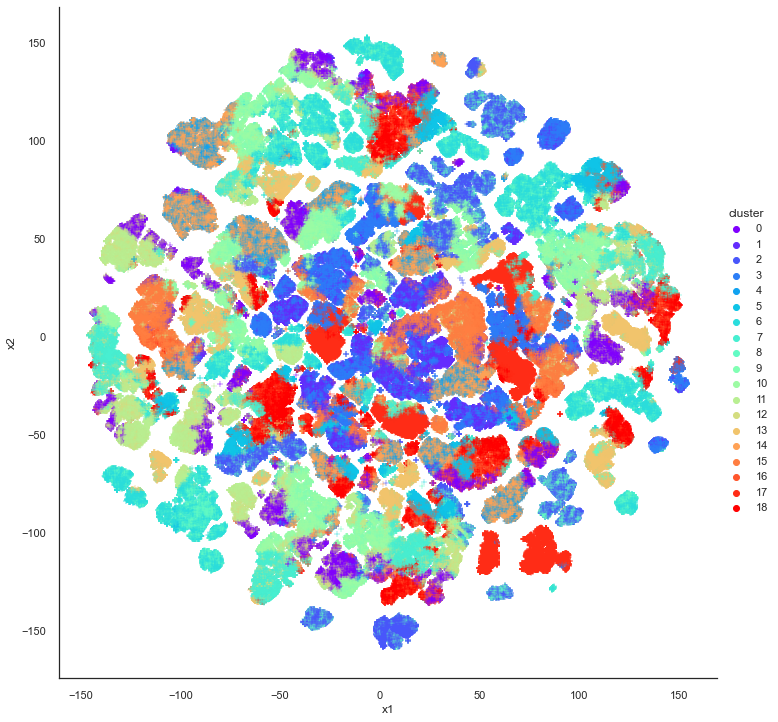

In [76]:
sns.set_theme(style="white")

sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [80]:
TSNE_data2 = scaled_df.copy()
sampleTSNE2 = TSNE_data2.sample(n=40000, random_state=1).reset_index()
#sampleTSNE2 = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X2 = sampleTSNE2.iloc[:,1:-1]

##########################################
tsne2 = TSNE(n_components=2, perplexity=200.0, n_iter=5000, verbose=1).fit_transform(X2)

tsne2

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.165s...
[t-SNE] Computed neighbors for 40000 samples in 17.736s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

array([[  43.885998 ,  -62.85302  ],
       [-101.8882   ,  -43.77825  ],
       [ -96.53445  ,  -32.8303   ],
       ...,
       [-114.76671  ,    5.218762 ],
       [  91.043    ,   19.38849  ],
       [  -5.9667177,   56.707447 ]], dtype=float32)

In [81]:
cluster_label_tsne2 = sampleTSNE2['cluster']

tsne_cluster2 = pd.DataFrame(tsne2)
tsne_cluster2['cluster'] = cluster_label_tsne2
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster2.columns = ['x1','x2','cluster']
tsne_cluster2.head()
#sampleTSNE['cluster']

,x1,x2,cluster
0,43.885998,-62.853020,18
1,-101.888199,-43.778252,17
2,-96.534447,-32.830299,18
3,-3.603068,-65.225548,7
4,2.020894,-63.511951,7


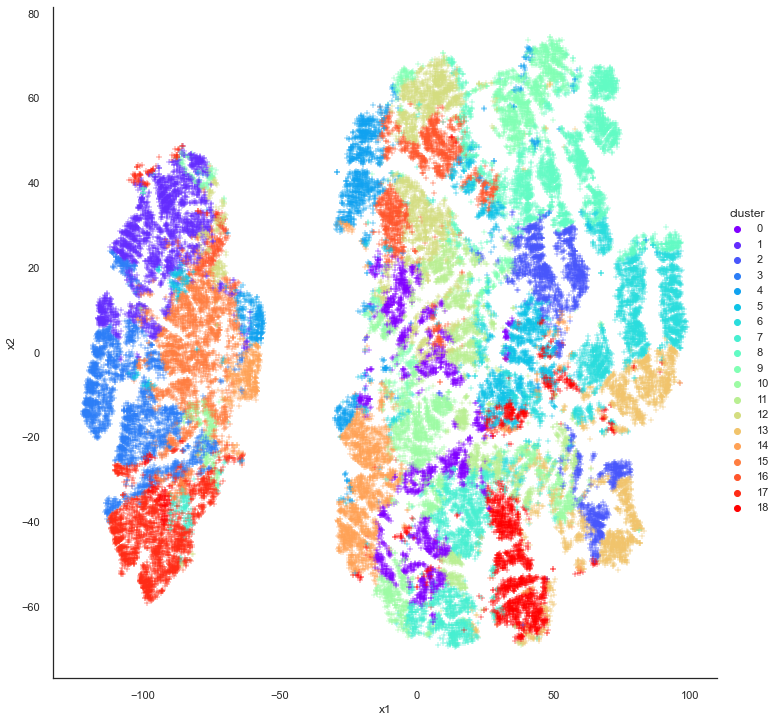

In [82]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster2, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [86]:
#TSNE_data3 = scaled_df.copy()
#sampleTSNE3 = TSNE_data3.sample(n=40000, random_state=1).reset_index()
sampleTSNE3 = scaled_df.copy()


from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X3 = sampleTSNE3.iloc[:,1:-1]

##########################################
tsne3 = TSNE(n_components=2, perplexity=50.0, n_iter=5000, verbose=1).fit_transform(X3)

tsne3

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 401622 samples in 1.886s...
[t-SNE] Computed neighbors for 401622 samples in 69.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 401622
[t-SNE] Computed conditional probabilities for sample 2000 / 401622
[t-SNE] Computed conditional probabilities for sample 3000 / 401622
[t-SNE] Computed conditional probabilities for sample 4000 / 401622
[t-SNE] Computed conditional probabilities for sample 5000 / 401622
[t-SNE] Computed conditional probabilities for sample 6000 / 401622
[t-SNE] Computed conditional probabilities for sample 7000 / 401622
[t-SNE] Computed conditional probabilities for sample 8000 / 401622
[t-SNE] Computed conditional probabilities for sample 9000 / 401622
[t-SNE] Computed conditional probabilities for sample 10000 / 401622
[t-SNE] Computed conditional probabilities for sample 11000 / 401622
[t-SNE] Computed conditional probabilities for sample 12000 / 401622
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 401622
[t-SNE] Computed conditional probabilities for sample 119000 / 401622
[t-SNE] Computed conditional probabilities for sample 120000 / 401622
[t-SNE] Computed conditional probabilities for sample 121000 / 401622
[t-SNE] Computed conditional probabilities for sample 122000 / 401622
[t-SNE] Computed conditional probabilities for sample 123000 / 401622
[t-SNE] Computed conditional probabilities for sample 124000 / 401622
[t-SNE] Computed conditional probabilities for sample 125000 / 401622
[t-SNE] Computed conditional probabilities for sample 126000 / 401622
[t-SNE] Computed conditional probabilities for sample 127000 / 401622
[t-SNE] Computed conditional probabilities for sample 128000 / 401622
[t-SNE] Computed conditional probabilities for sample 129000 / 401622
[t-SNE] Computed conditional probabilities for sample 130000 / 401622
[t-SNE] Computed conditional probabilities for sample 131000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 236000 / 401622
[t-SNE] Computed conditional probabilities for sample 237000 / 401622
[t-SNE] Computed conditional probabilities for sample 238000 / 401622
[t-SNE] Computed conditional probabilities for sample 239000 / 401622
[t-SNE] Computed conditional probabilities for sample 240000 / 401622
[t-SNE] Computed conditional probabilities for sample 241000 / 401622
[t-SNE] Computed conditional probabilities for sample 242000 / 401622
[t-SNE] Computed conditional probabilities for sample 243000 / 401622
[t-SNE] Computed conditional probabilities for sample 244000 / 401622
[t-SNE] Computed conditional probabilities for sample 245000 / 401622
[t-SNE] Computed conditional probabilities for sample 246000 / 401622
[t-SNE] Computed conditional probabilities for sample 247000 / 401622
[t-SNE] Computed conditional probabilities for sample 248000 / 401622
[t-SNE] Computed conditional probabilities for sample 249000 / 401622
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 356000 / 401622
[t-SNE] Computed conditional probabilities for sample 357000 / 401622
[t-SNE] Computed conditional probabilities for sample 358000 / 401622
[t-SNE] Computed conditional probabilities for sample 359000 / 401622
[t-SNE] Computed conditional probabilities for sample 360000 / 401622
[t-SNE] Computed conditional probabilities for sample 361000 / 401622
[t-SNE] Computed conditional probabilities for sample 362000 / 401622
[t-SNE] Computed conditional probabilities for sample 363000 / 401622
[t-SNE] Computed conditional probabilities for sample 364000 / 401622
[t-SNE] Computed conditional probabilities for sample 365000 / 401622
[t-SNE] Computed conditional probabilities for sample 366000 / 401622
[t-SNE] Computed conditional probabilities for sample 367000 / 401622
[t-SNE] Computed conditional probabilities for sample 368000 / 401622
[t-SNE] Computed conditional probabilities for sample 369000 / 401622
[t-SNE] Computed con

array([[ 123.641815 ,  -41.149055 ],
       [-161.95703  ,   15.340228 ],
       [   4.7389526,   77.30574  ],
       ...,
       [ -43.682083 ,   53.68488  ],
       [-112.53423  ,   11.793158 ],
       [ -38.359024 ,   56.592514 ]], dtype=float32)

In [87]:
cluster_label_tsne3 = sampleTSNE3['cluster']

tsne_cluster3 = pd.DataFrame(tsne3)
tsne_cluster3['cluster'] = cluster_label_tsne3
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster3.columns = ['x1','x2','cluster']
tsne_cluster3.head()
#sampleTSNE['cluster']

,x1,x2,cluster
0,123.641815,-41.149055,0
1,-161.957031,15.340228,6
2,4.738953,77.305740,5
3,6.759074,73.844200,11
4,7.588920,-22.451591,0


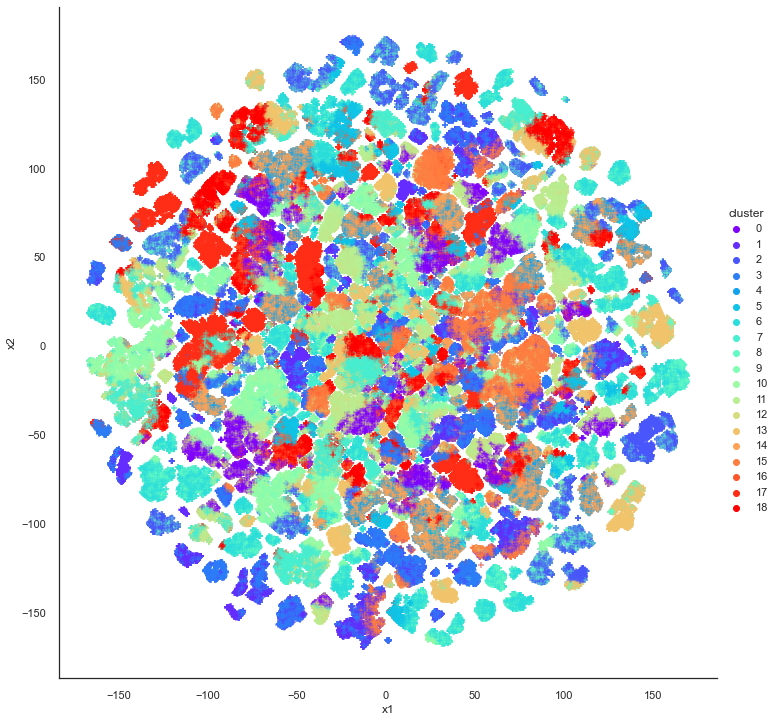

In [88]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster3, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

#### Radar plot

In [89]:
#clustered_data.groupby(['cluster']).describe()

### Distribution of trip types among mobility modes

In [30]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [31]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,2.894317
1,1.627486
2,7.612127
3,4.818909
4,6.899483
5,3.464597
6,2.478780
7,5.031423
8,8.358608


In [32]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,10.783891
1,8.156543
2,1.603859
3,6.925219
4,3.450845
5,11.160347
6,7.587938
7,3.282224
8,5.580173


In [33]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,11.236770
1,9.208127
2,1.577169
3,8.222956
4,3.891347
5,13.498625
6,9.294086
7,5.090295
8,0.659272
